Loading and pre-processing data...
Found regions: ['Central', 'Eastern', 'Northern', 'Northwest', 'Southwest']

STARTING SIMULATION FOR REGION: Central

--- Running Algorithm: RL (Gittins Index) for Central ---
Week of 2021-05-31: Pool size is 33 (<50). Skipping sampling.
Week 2021-06-07: Pool=121, Budget=200
Week 2021-06-14: Pool=463, Budget=200
Week 2021-06-21: Pool=854, Budget=200
Week 2021-06-28: Pool=1467, Budget=200
Week 2021-07-05: Pool=2563, Budget=200
Week 2021-07-12: Pool=4767, Budget=200
Week 2021-07-19: Pool=8938, Budget=200
Week 2021-07-26: Pool=14491, Budget=200
Week 2021-08-02: Pool=18613, Budget=200
Week 2021-08-09: Pool=18464, Budget=200
Week 2021-08-16: Pool=15539, Budget=200
Week 2021-08-23: Pool=12171, Budget=200
Week 2021-08-30: Pool=9182, Budget=200
Week 2021-09-06: Pool=6960, Budget=200
Week 2021-09-13: Pool=5581, Budget=200
Week 2021-09-20: Pool=4612, Budget=200
Week 2021-09-27: Pool=3982, Budget=200
Week 2021-10-04: Pool=3758, Budget=200
Week of 2021-10-11: Poo

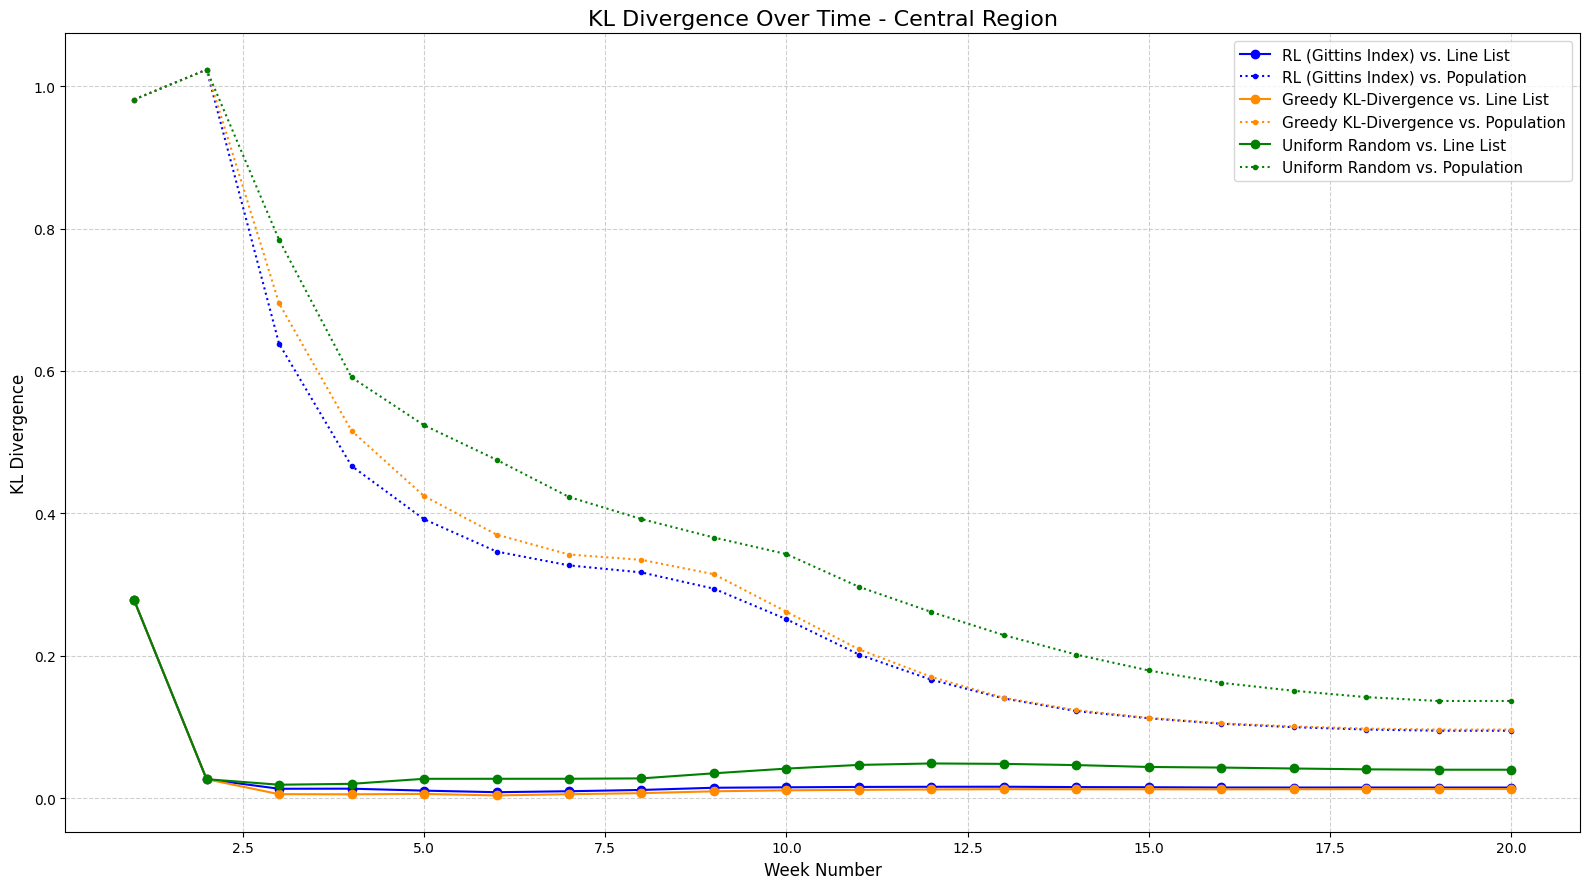

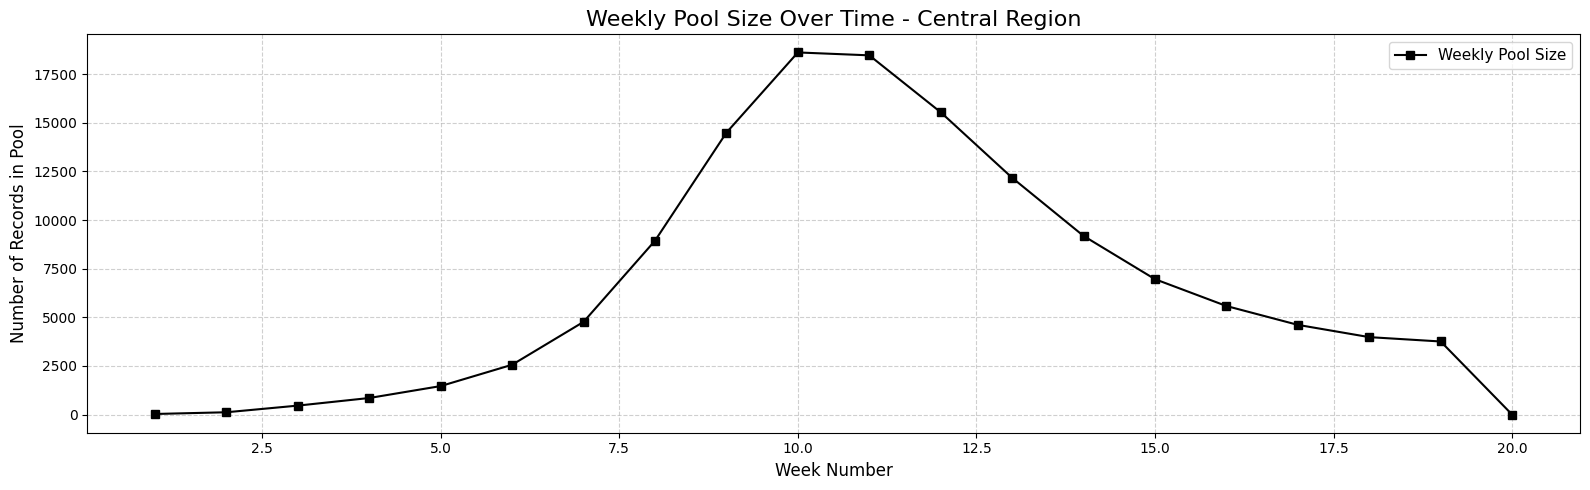


--- Generating plots for Eastern ---


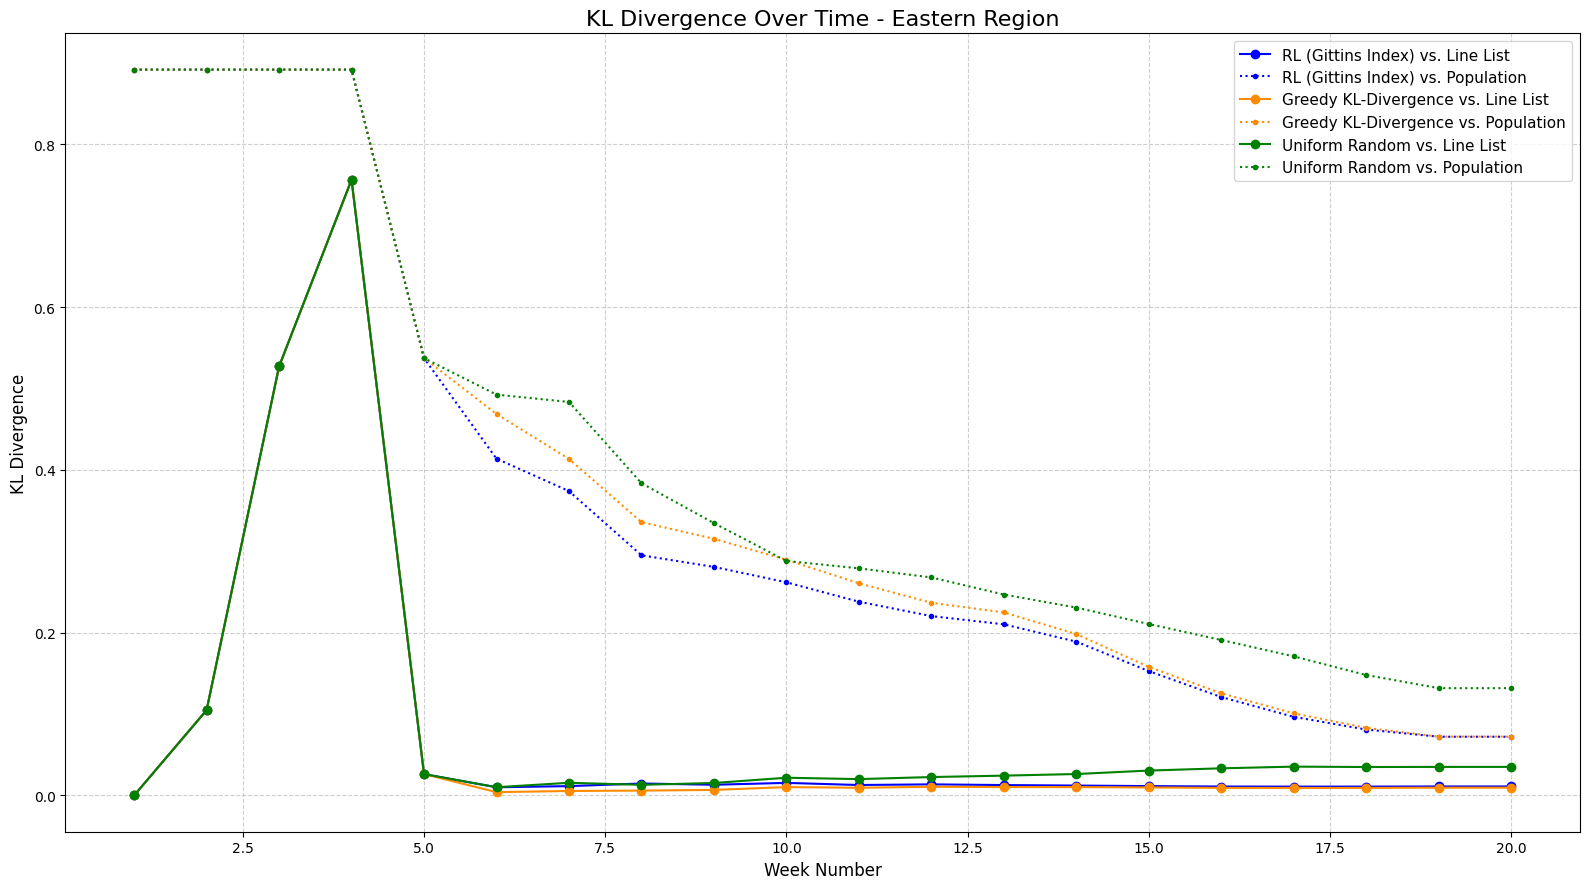

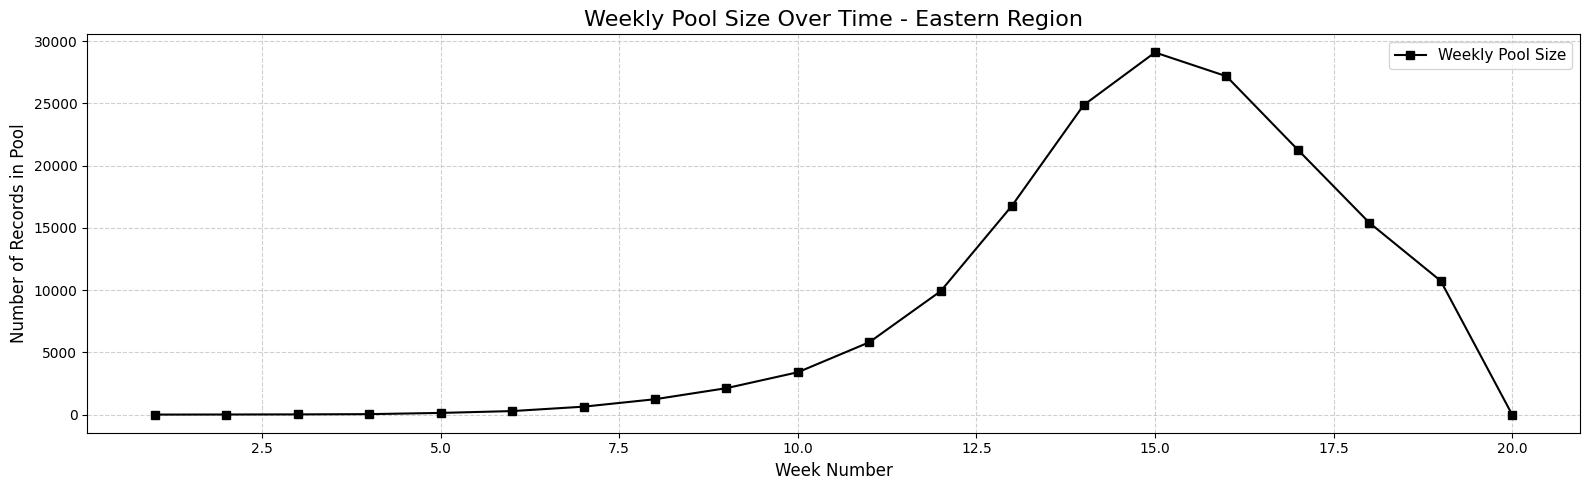


--- Generating plots for Northern ---


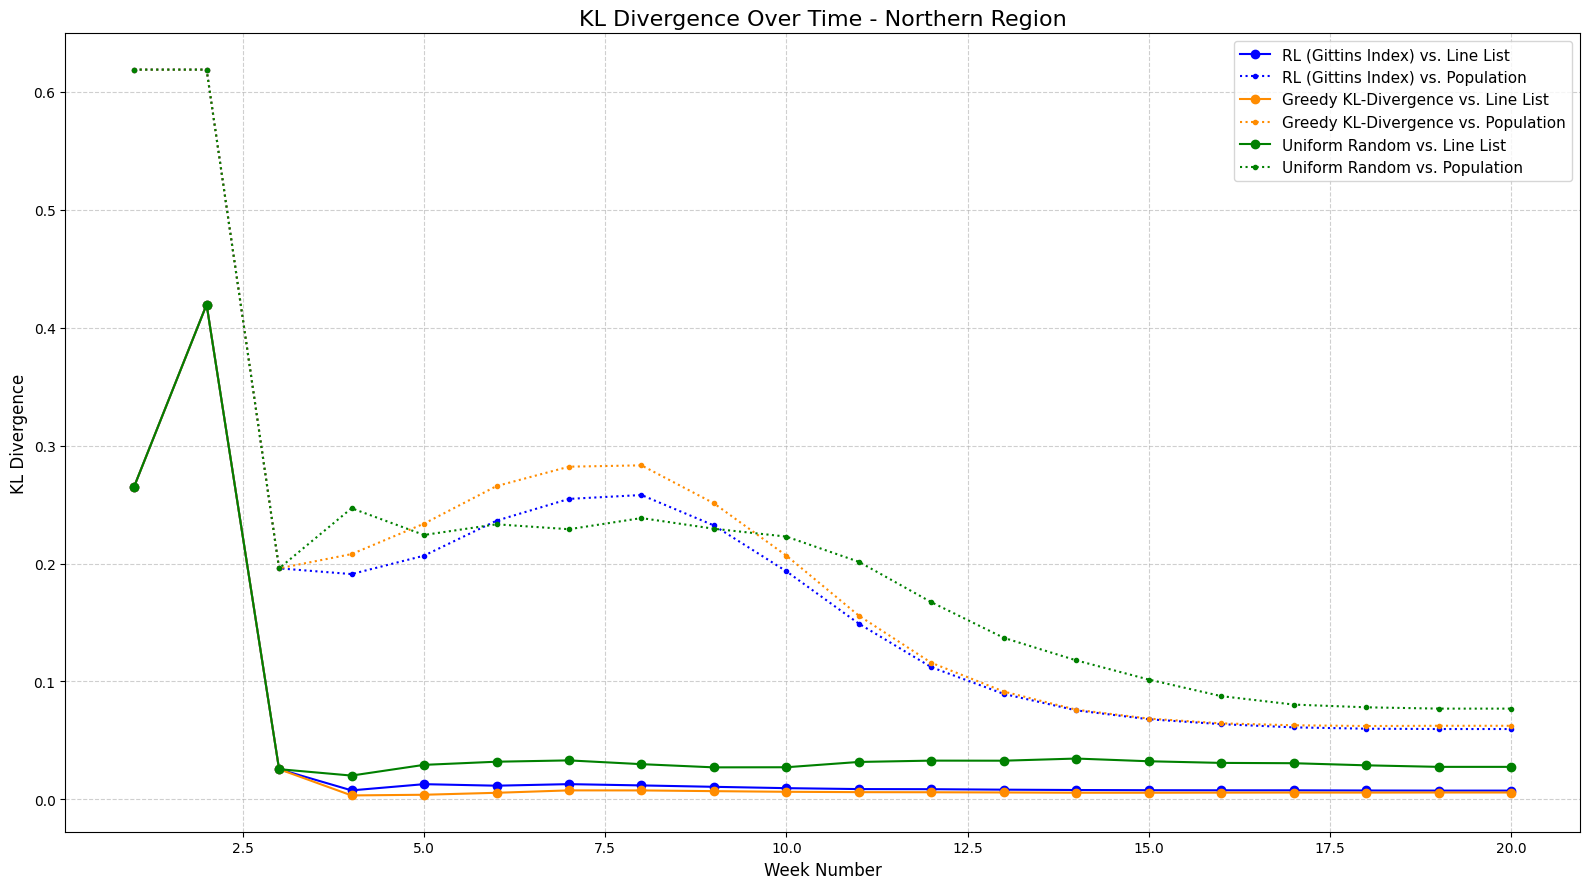

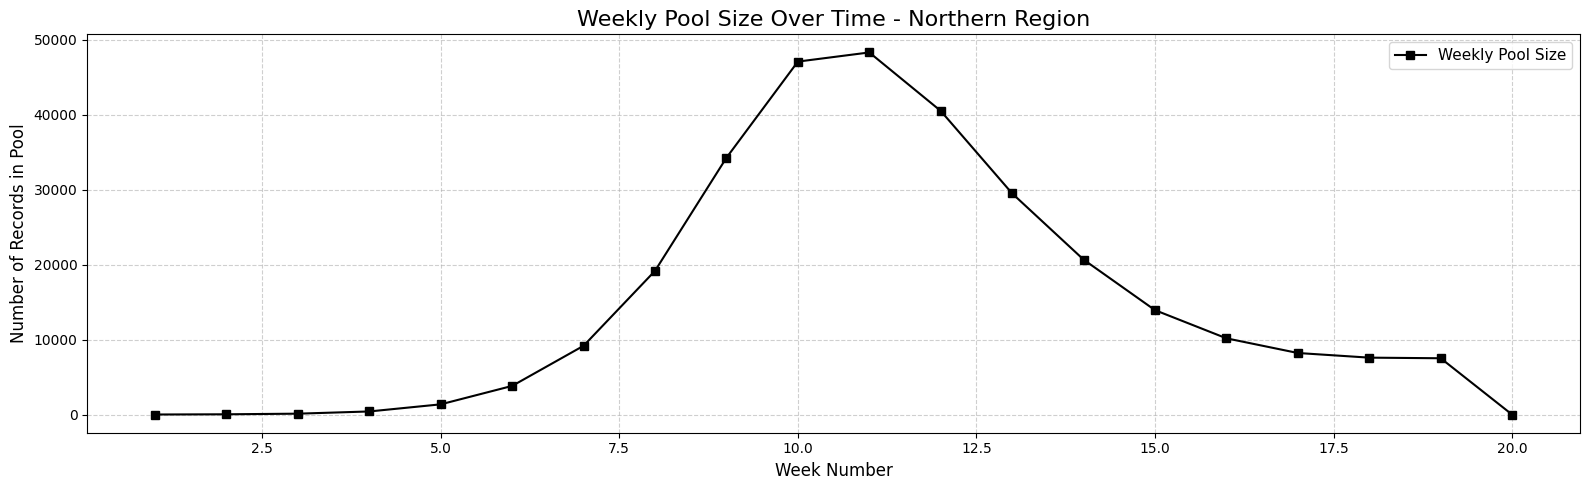


--- Generating plots for Northwest ---


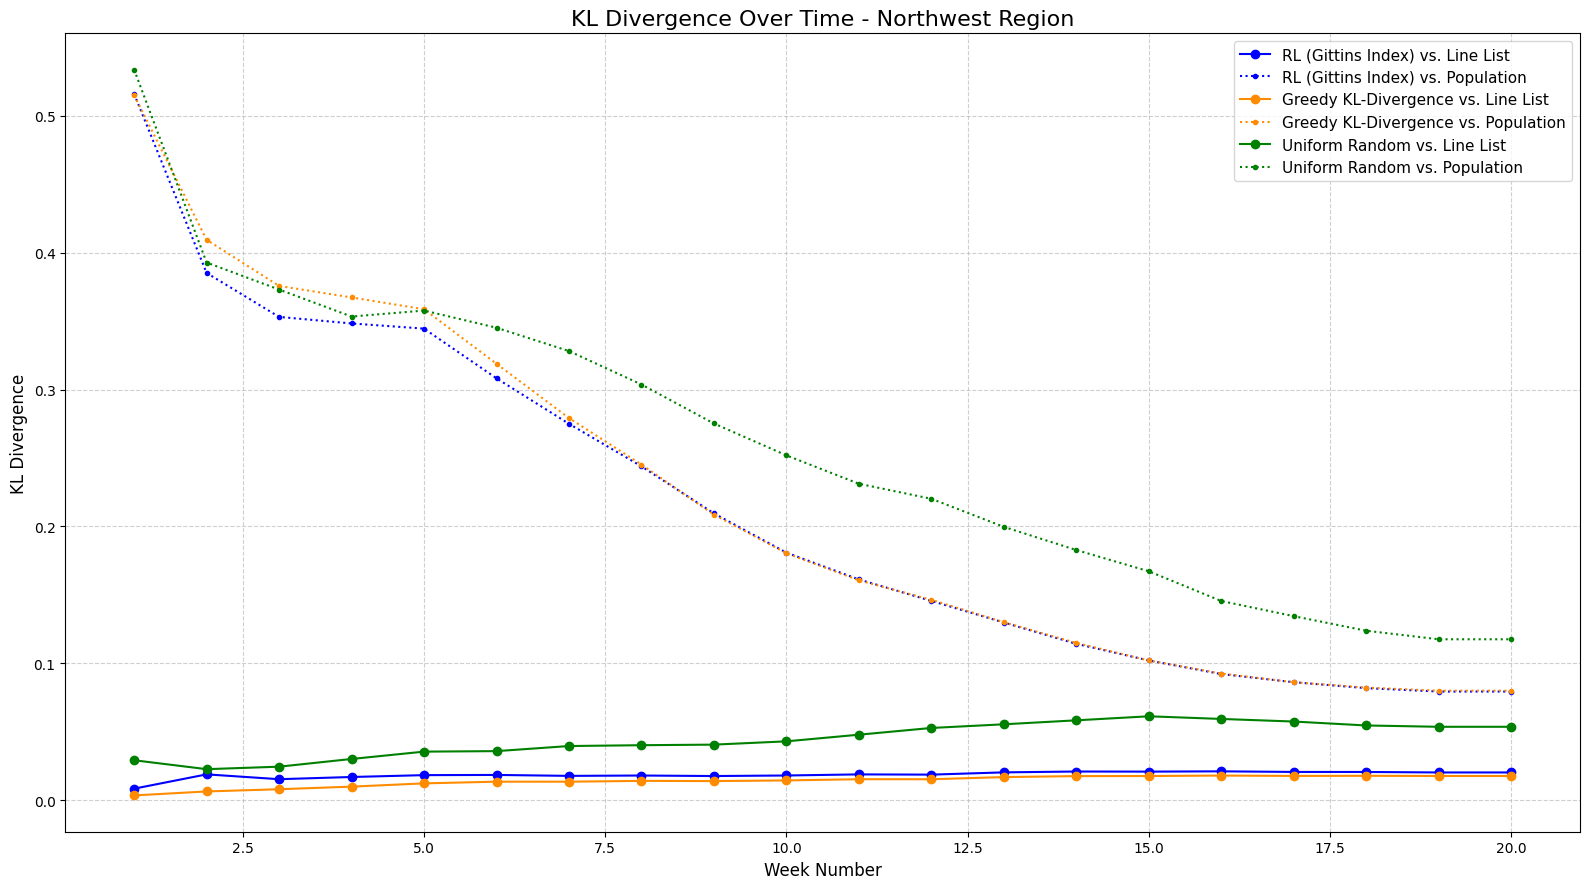

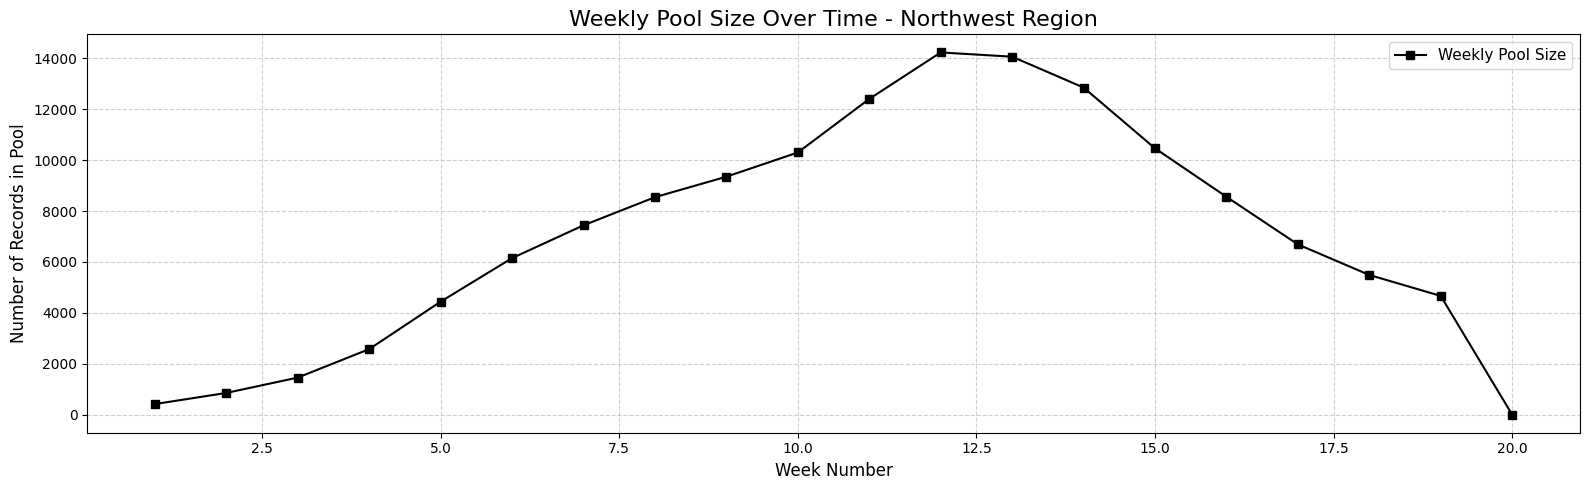


--- Generating plots for Southwest ---


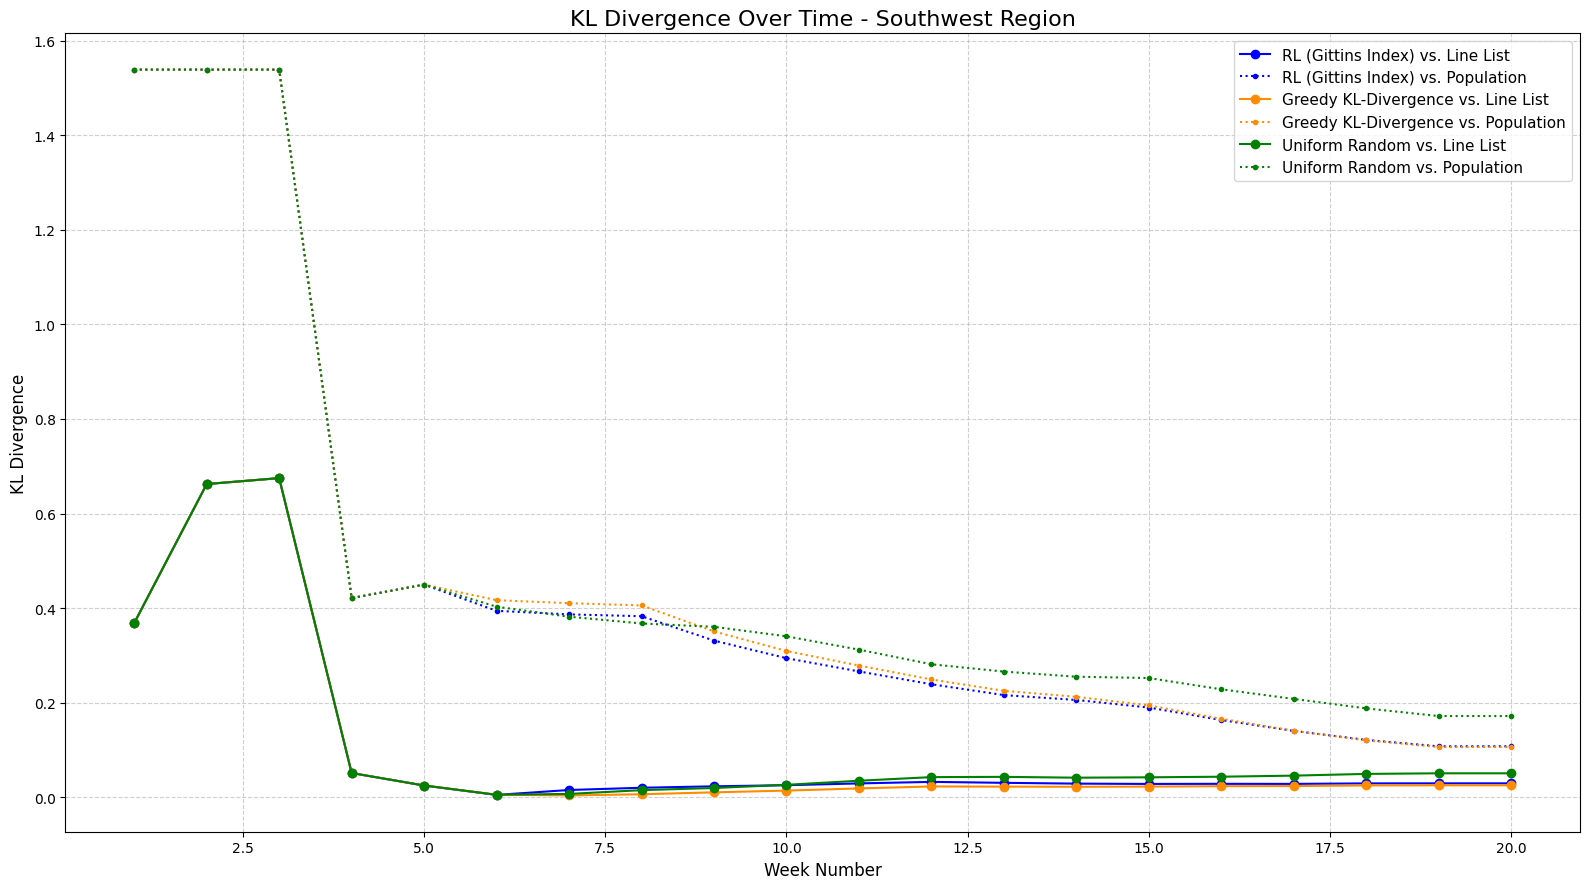

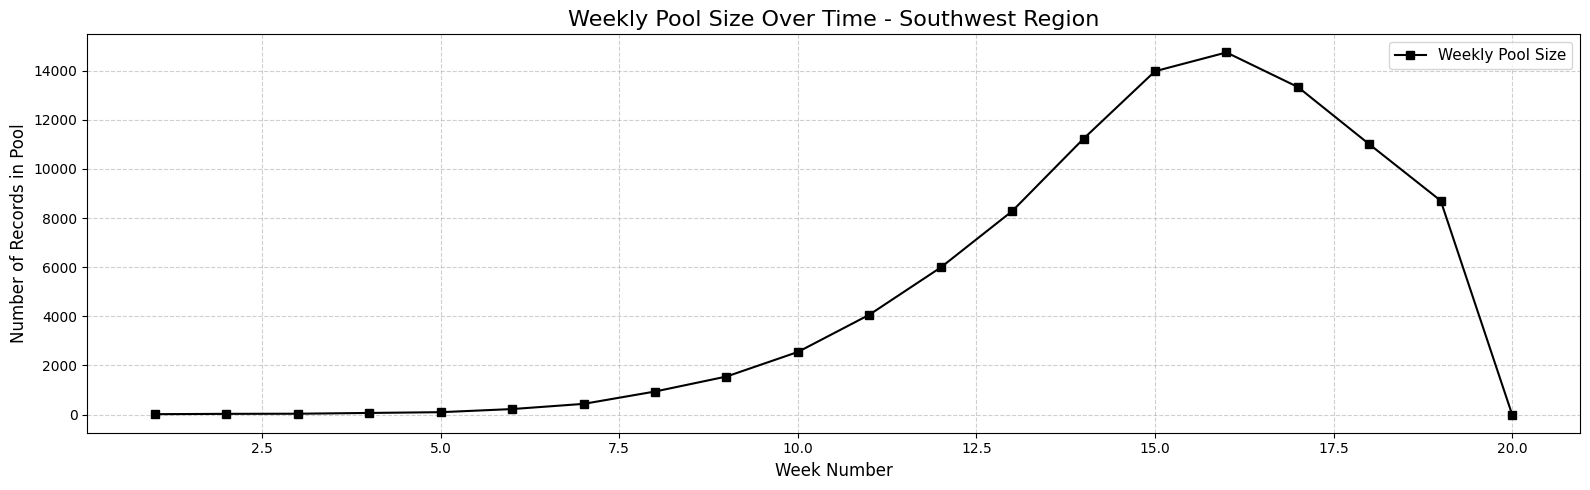


--- Aggregating results and plotting mean KL-Divergence across all regions ---


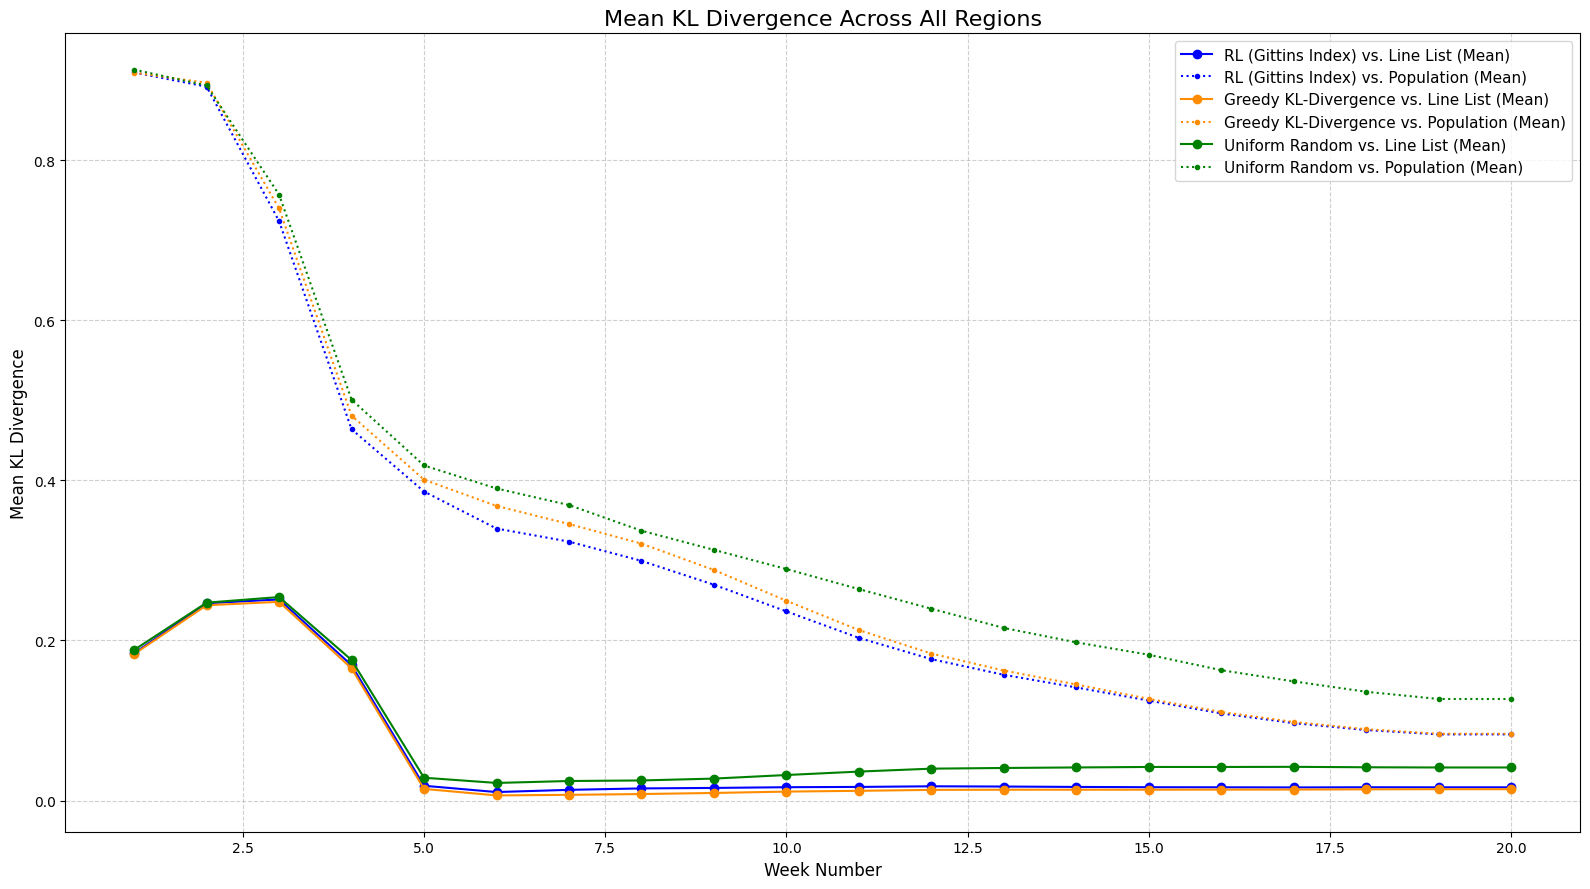

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
from datetime import timedelta
import matplotlib.pyplot as plt
import time
import networkx as nx
from collections import defaultdict

# -------------------------
# CONFIGURATION
# -------------------------
LINE_LIST_FILE = "linelist_with_regions.csv"
POPULATION_FILE = "va_persontrait_epihiper.txt"
REGION_FIELD = 'VDH_Region_Name'
REGION_BUDGET = 200
DATE_FIELD = "date"
START_DATE = pd.to_datetime("2021-05-31")
END_DATE = pd.to_datetime("2021-10-11")
MINIMUM_POOL_SIZE = 50
MIN_PER_GROUP = 1
GROUP_FEATURES = ['age_group', 'smh_race']

# -------------------------
# UTILS
# -------------------------
def make_group(df, features):
    df = df.copy()
    for col in features:
        df[col] = df[col].astype(str).str.strip()
    df['group'] = df[features].agg('_'.join, axis=1)
    return df

# -------------------------
# ALGORITHM DEFINITIONS
# (No changes needed in these functions)
# -------------------------
def reward_function(group, all_samples, target_dist):
    current_dist = pd.Series(all_samples).value_counts(normalize=True)
    curr_freq = current_dist.get(group, 1e-6)
    target_freq = target_dist.get(group, 1e-6)
    return -np.log(curr_freq / target_freq)

def gittins_sampler_with_min_coverage(line_df, target_dist, batch_size, min_per_group, pulls, rewards, cumulative_sampled_groups):
    sampled_this_week_groups = []
    line_df = line_df.copy()
    group_counts = line_df['group'].value_counts()
    available_groups_this_week = group_counts.index.tolist()
    initial_samples = []
    for g in target_dist.index:
        if g in group_counts and group_counts[g] > 0:
            count = min(min_per_group, group_counts[g])
            sample = line_df[line_df['group'] == g].sample(count)
            initial_samples.append(sample)
            sampled_this_week_groups.extend([g] * count)
            group_counts[g] -= count
    remaining = batch_size - len(sampled_this_week_groups)
    if remaining <= 0: return pd.concat(initial_samples, ignore_index=True) if initial_samples else pd.DataFrame()
    for g in sampled_this_week_groups:
        pulls[g] = pulls.get(g, 0) + 1
        rewards[g] = rewards.get(g, 0.0) + reward_function(g, cumulative_sampled_groups + sampled_this_week_groups, target_dist)
    for _ in range(remaining):
        best_group, best_index = None, -np.inf
        current_cumulative_dist = pd.Series(cumulative_sampled_groups + sampled_this_week_groups).value_counts(normalize=True)
        total_pulls = sum(pulls.values())
        for g in available_groups_this_week:
            if group_counts.get(g, 0) > 0:
                mean_reward = rewards.get(g, 0.0) / pulls.get(g, 1)
                exploration_bonus = np.sqrt(np.log(total_pulls + 1) / (pulls.get(g, 0) + 1))
                curr_freq = current_cumulative_dist.get(g, 1e-6)
                target_freq = target_dist.get(g, 1e-6)
                under_rep_boost = np.log(1 + (target_freq / (curr_freq + 1e-6)))
                gittins_score = mean_reward + exploration_bonus + under_rep_boost
                if gittins_score > best_index: best_index, best_group = gittins_score, g
        if best_group:
            sampled_this_week_groups.append(best_group)
            pulls[best_group] = pulls.get(best_group, 0) + 1
            rewards[best_group] = rewards.get(best_group, 0.0) + reward_function(best_group, cumulative_sampled_groups + sampled_this_week_groups, target_dist)
            group_counts[best_group] -= 1
    sample_counts = pd.Series(sampled_this_week_groups).value_counts()
    final_samples = [df for df in initial_samples]
    for g, count in sample_counts.items():
        initial_count = sum(len(df[df['group'] == g]) for df in initial_samples)
        remaining_count = count - initial_count
        if remaining_count > 0:
            pool = line_df[line_df['group'] == g]
            final_samples.append(pool.sample(min(remaining_count, len(pool))))
    return pd.concat(final_samples, ignore_index=True) if final_samples else pd.DataFrame()

def greedy_kl_sampler(line_df, target_dist, batch_size, min_per_group, cumulative_sampled_groups):
    this_week_sampled_groups = []
    line_df = line_df.copy()
    group_counts = line_df['group'].value_counts().to_dict()
    target_groups = target_dist.index.tolist()
    initial_samples_df_list = []
    for g in target_groups:
        if g in group_counts and group_counts[g] > 0:
            count = min(min_per_group, group_counts[g])
            sample_df = line_df[line_df['group'] == g].sample(count)
            initial_samples_df_list.append(sample_df)
            this_week_sampled_groups.extend([g] * count)
            group_counts[g] -= count
    remaining = batch_size - len(this_week_sampled_groups)
    if remaining <= 0: return pd.concat(initial_samples_df_list, ignore_index=True) if initial_samples_df_list else pd.DataFrame()
    for _ in range(remaining):
        best_group, best_kl = None, float('inf')
        candidate_groups = [g for g, count in group_counts.items() if count > 0]
        for g in candidate_groups:
            trial_cumulative_groups = cumulative_sampled_groups + this_week_sampled_groups + [g]
            trial_dist = pd.Series(trial_cumulative_groups).value_counts(normalize=True)
            trial_dist_aligned = trial_dist.reindex(target_dist.index, fill_value=0.0)
            kl = entropy(trial_dist_aligned + 1e-9, target_dist.reindex(trial_dist_aligned.index) + 1e-9)
            if kl < best_kl: best_group, best_kl = g, kl
        if best_group:
            this_week_sampled_groups.append(best_group)
            group_counts[best_group] -= 1
        else: break
    sample_counts = pd.Series(this_week_sampled_groups).value_counts()
    final_samples_df_list = []
    for g, count in sample_counts.items():
        pool = line_df[line_df['group'] == g]
        final_samples_df_list.append(pool.sample(min(count, len(pool))))
    return pd.concat(final_samples_df_list, ignore_index=True) if final_samples_df_list else pd.DataFrame()

def uniform_sampler_with_min_coverage(line_df, target_dist, batch_size, min_per_group):
    line_df = line_df.copy()
    group_counts = line_df['group'].value_counts()
    target_groups = target_dist.index.tolist()
    initial_samples_df_list = []
    for g in target_groups:
        if g in group_counts and group_counts[g] > 0:
            count = min(min_per_group, group_counts[g])
            sample = line_df[line_df['group'] == g].sample(count)
            initial_samples_df_list.append(sample)
    if initial_samples_df_list:
        initial_df = pd.concat(initial_samples_df_list)
        line_df = line_df.drop(initial_df.index)
    else: initial_df = pd.DataFrame()
    remaining = batch_size - len(initial_df)
    if remaining <= 0: return initial_df
    num_to_sample = min(remaining, len(line_df))
    random_samples_df = line_df.sample(num_to_sample, replace=False) if num_to_sample > 0 else pd.DataFrame()
    return pd.concat([initial_df, random_samples_df], ignore_index=True)


# -------------------------
# DATA LOADING & PRE-PROCESSING
# -------------------------
print("Loading and pre-processing data...")
line_df = pd.read_csv(LINE_LIST_FILE, parse_dates=[DATE_FIELD])
pop_df = pd.read_csv(POPULATION_FILE, skiprows=1)

try:
    regions_info_df = pd.read_csv('VA_Gov_Regions_named.csv', dtype={'GEOID': str})
    regions_info_df = regions_info_df.rename(columns={'GEOID': 'county_fips'})
    pop_df['county_fips'] = pop_df['county_fips'].astype(str) # Ensure FIPS is string for merging
    pop_df = pd.merge(pop_df, regions_info_df[['county_fips', REGION_FIELD]], on='county_fips', how='left')
    pop_df.dropna(subset=[REGION_FIELD], inplace=True)
except Exception as e:
    print(f"Could not merge region data into population data: {e}")
    print("Please ensure your population file has a FIPS code column named 'county_fips' and 'regions.csv' exists.")
    exit()

pop_df["age_group"] = pop_df["age_group"].map({"p": "Preschool (0-4)", "s": "Student (5-17)", "a": "Adult (18-49)", "o": "Older adult (50-64)", "g": "Senior (65+)"})
pop_df["smh_race"] = pop_df["smh_race"].astype(str).map({"W": "White", "B": "Black", "L": "Latino", "A": "Asian", "O": "Other"})
line_df = make_group(line_df, GROUP_FEATURES)
pop_df = make_group(pop_df, GROUP_FEATURES)

POP_DIST_STATIC_REGIONAL = {
    region: df['group'].value_counts(normalize=True).sort_index()
    for region, df in pop_df.groupby(REGION_FIELD)
}
all_regions = sorted(line_df[REGION_FIELD].dropna().unique())
print(f"Found regions: {all_regions}")


# -------------------------
# EXPERIMENT EXECUTION
# -------------------------
algorithms = {
    "RL (Gittins Index)": gittins_sampler_with_min_coverage,
    "Greedy KL-Divergence": greedy_kl_sampler,
    "Uniform Random": uniform_sampler_with_min_coverage
}

regional_results_history = {region: {} for region in all_regions}
regional_weekly_linelist_history = {region: [] for region in all_regions}
regional_pool_size_history = {region: [] for region in all_regions}

for region in all_regions:
    print(f"\n{'='*40}\nSTARTING SIMULATION FOR REGION: {region}\n{'='*40}")

    region_line_df = line_df[line_df[REGION_FIELD] == region].copy()

    for name, sampler_func in algorithms.items():
        print(f"\n--- Running Algorithm: {name} for {region} ---")
        start_time = time.time()
        current_week = START_DATE

        cumulative_linelist_dfs, weekly_sample_history = [], []
        cumulative_sampled_groups = []
        pulls, rewards = {}, {}

        # MODIFIED: The loop now runs until the specified END_DATE
        while current_week <= END_DATE:
            prev_mon = current_week - timedelta(days=7)
            prev_sun = current_week - timedelta(days=1)

            mask = (region_line_df[DATE_FIELD] >= prev_mon) & (region_line_df[DATE_FIELD] <= prev_sun)
            week_df = region_line_df[mask]
            pool_size = len(week_df)

            # This part runs only for the first algorithm to log region-wide weekly data
            if name == next(iter(algorithms)):
                regional_pool_size_history[region].append(pool_size)
                regional_weekly_linelist_history[region].append(week_df['group'].value_counts())

            # --- MODIFIED LOGIC: Skip week instead of stopping ---
            if pool_size < MINIMUM_POOL_SIZE:
                print(f"Week of {current_week.date()}: Pool size is {pool_size} (<{MINIMUM_POOL_SIZE}). Skipping sampling.")
                # Append an empty result to keep the history timeline consistent
                weekly_sample_history.append(pd.Series(dtype='int64'))
                # Advance to the next week and skip the rest of the loop
                current_week += timedelta(weeks=1)
                continue
            # --- End of modified logic ---

            print(f"Week {current_week.date()}: Pool={pool_size}, Budget={REGION_BUDGET}")

            cumulative_linelist_dfs.append(week_df)
            cumulative_linelist_pool = pd.concat(cumulative_linelist_dfs, ignore_index=True)
            target_dist = cumulative_linelist_pool['group'].value_counts(normalize=True).sort_index()

            # Run the sampling algorithm to get the weekly sample
            if name == "RL (Gittins Index)":
                sample_df = sampler_func(week_df, target_dist, REGION_BUDGET, MIN_PER_GROUP, pulls, rewards, cumulative_sampled_groups)
            elif name == "Greedy KL-Divergence":
                sample_df = sampler_func(week_df, target_dist, REGION_BUDGET, MIN_PER_GROUP, cumulative_sampled_groups)
            else: # Uniform
                sample_df = sampler_func(week_df, target_dist, REGION_BUDGET, MIN_PER_GROUP)

            # Update histories with this week's results
            weekly_sample_history.append(sample_df['group'].value_counts())
            cumulative_sampled_groups.extend(sample_df['group'].tolist())

            # Advance to the next week
            current_week += timedelta(weeks=1)

        end_time = time.time()
        print(f"--- {name} for {region} finished in {end_time - start_time:.2f} seconds ---")

        regional_results_history[region][name] = weekly_sample_history

# -------------------------
# PLOTTING
# -------------------------

# MODIFIED: KL-divergence CALCULATION functions (separated from plotting)
def calculate_kl_values_static(weekly_history, static_target_dist):
    """Calculates KL divergence against a static population target."""
    cumulative_counts = pd.Series(dtype=float)
    kl_values = []
    for weekly_counts in weekly_history:
        cumulative_counts = cumulative_counts.add(weekly_counts, fill_value=0)
        cum_dist = cumulative_counts / cumulative_counts.sum()
        s_dist = cum_dist.reindex(static_target_dist.index, fill_value=1e-9)
        t_dist = static_target_dist.reindex(s_dist.index, fill_value=1e-9)
        kl = entropy(s_dist, t_dist)
        kl_values.append(kl)
    return kl_values

def calculate_kl_values_dynamic(weekly_sample_hist, weekly_linelist_hist):
    """Calculates KL divergence against a dynamic line list target."""
    cumulative_sample_counts = pd.Series(dtype=float)
    cumulative_linelist_counts = pd.Series(dtype=float)
    kl_values = []
    num_weeks = min(len(weekly_sample_hist), len(weekly_linelist_hist))
    for i in range(num_weeks):
        cumulative_sample_counts = cumulative_sample_counts.add(weekly_sample_hist[i], fill_value=0)
        cumulative_linelist_counts = cumulative_linelist_counts.add(weekly_linelist_hist[i], fill_value=0)
        cum_sample_dist = cumulative_sample_counts / cumulative_sample_counts.sum()
        cum_linelist_dist = cumulative_linelist_counts / cumulative_linelist_counts.sum()
        all_groups = cum_sample_dist.index.union(cum_linelist_dist.index)
        s_dist = cum_sample_dist.reindex(all_groups, fill_value=1e-9)
        t_dist = cum_linelist_dist.reindex(all_groups, fill_value=1e-9)
        kl = entropy(s_dist, t_dist)
        kl_values.append(kl)
    return kl_values

# --- Plot 1: Generate plots for each region individually ---
for region in all_regions:
    results_history = regional_results_history.get(region)
    if not results_history or not any(results_history.values()):
        print(f"No results to plot for {region}.")
        continue

    weekly_linelist_history = regional_weekly_linelist_history[region]
    POP_DIST_STATIC = POP_DIST_STATIC_REGIONAL[region]
    pool_size_history = regional_pool_size_history[region]
    
    print(f"\n--- Generating plots for {region} ---")

    # --- KL Divergence Plot per Region ---
    plt.figure(figsize=(16, 9))
    plt.title(f"KL Divergence Over Time - {region} Region", fontsize=16)
    plt.xlabel("Week Number", fontsize=12)
    plt.ylabel("KL Divergence", fontsize=12)
    colors = {"RL (Gittins Index)": "blue", "Greedy KL-Divergence": "darkorange", "Uniform Random": "green"}
    
    for name, weekly_history in results_history.items():
        kl_dynamic = calculate_kl_values_dynamic(weekly_history, weekly_linelist_history)
        plt.plot(range(1, len(kl_dynamic) + 1), kl_dynamic, marker='o', linestyle='-', label=f"{name} vs. Line List", color=colors[name])
        
        kl_static = calculate_kl_values_static(weekly_history, POP_DIST_STATIC)
        plt.plot(range(1, len(kl_static) + 1), kl_static, marker='.', linestyle=':', label=f"{name} vs. Population", color=colors[name])
        
    plt.legend(fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    # --- Pool Size Plot per Region ---
    plt.figure(figsize=(16, 5))
    plt.title(f"Weekly Pool Size Over Time - {region} Region", fontsize=16)
    plt.xlabel("Week Number", fontsize=12)
    plt.ylabel("Number of Records in Pool", fontsize=12)
    plt.plot(range(1, len(pool_size_history) + 1), pool_size_history, marker='s', color='black', linestyle='-', label='Weekly Pool Size')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.show()


--- Aggregating results and plotting mean KL-Divergence across all regions ---

      Mean Weekly KL Divergence Across All Regions
      RL (Gittins Index) vs. Line List  RL (Gittins Index) vs. Population  Greedy KL-Divergence vs. Line List  \
Week                                                                                                            
1                             0.183950                           0.909369                            0.182962   
2                             0.246382                           0.891601                            0.243886   
3                             0.251164                           0.723613                            0.248177   
4                             0.168973                           0.463702                            0.165119   
5                             0.018435                           0.385925                            0.014514   
6                             0.010560                           0.339704    

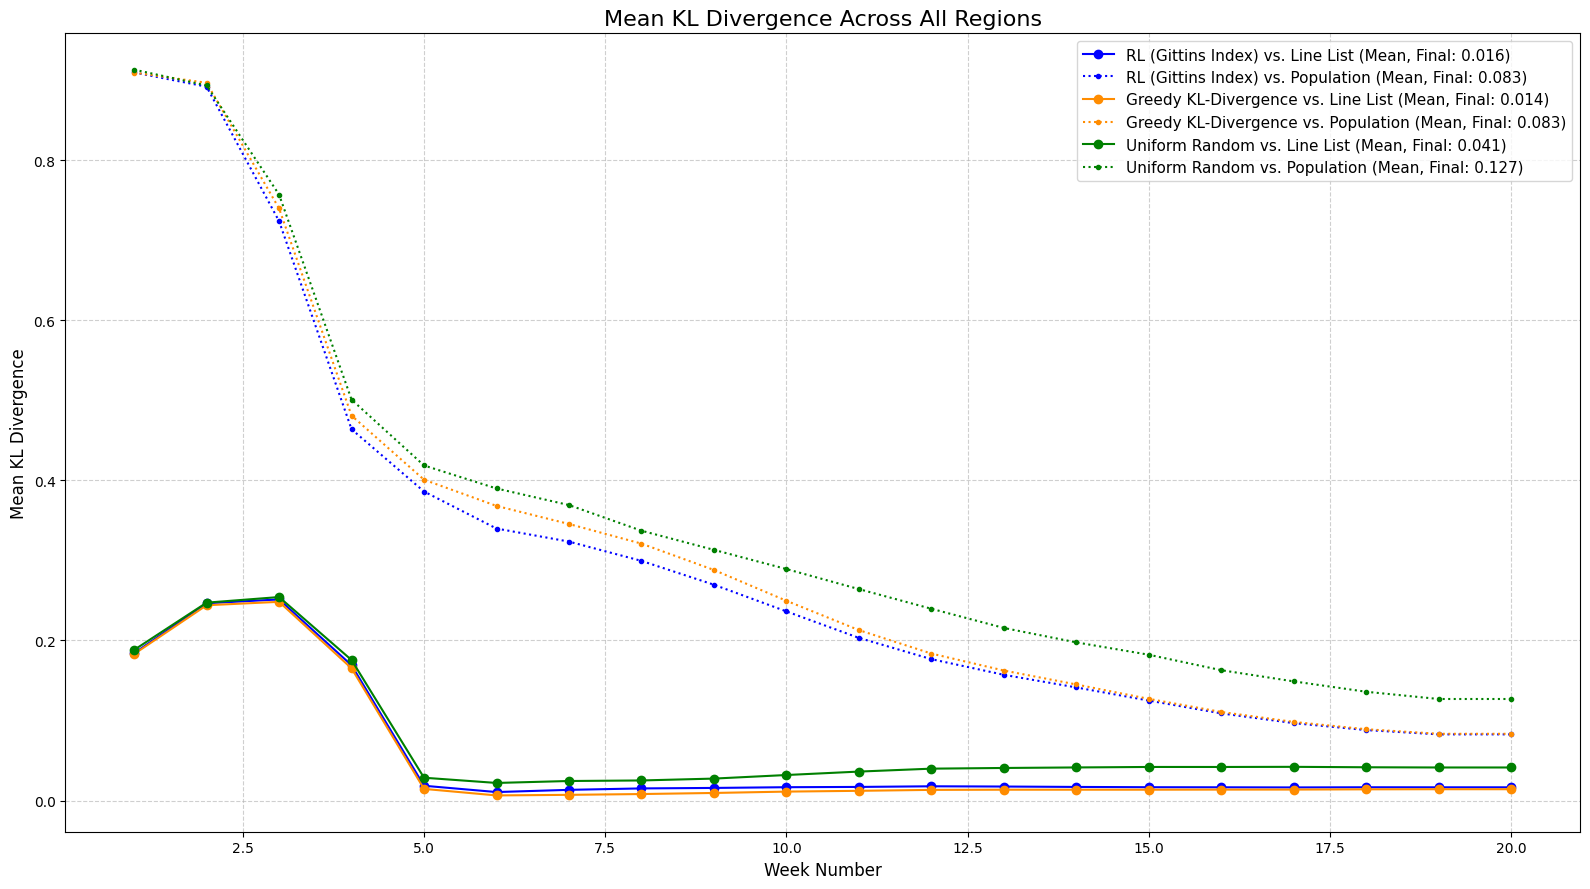

In [6]:
# --- NEW: Aggregate results and plot the mean KL-Divergence ---
print("\n--- Aggregating results and plotting mean KL-Divergence across all regions ---")

kl_dynamic_all_regions = {name: [] for name in algorithms}
kl_static_all_regions = {name: [] for name in algorithms}

# Loop through regions and algorithms to calculate and collect KL values
for region in all_regions:
    results_history = regional_results_history.get(region)
    if not results_history: continue
    
    for name, weekly_history in results_history.items():
        kl_dynamic_all_regions[name].append(calculate_kl_values_dynamic(weekly_history, regional_weekly_linelist_history[region]))
        kl_static_all_regions[name].append(calculate_kl_values_static(weekly_history, POP_DIST_STATIC_REGIONAL[region]))

# --- MODIFIED: Prepare data for both printing and plotting ---
# Create a dictionary to hold the results for our summary table
summary_data = {}

# Create the summary plot figure
plt.figure(figsize=(16, 9))
plt.title("Mean KL Divergence Across All Regions", fontsize=16)
plt.xlabel("Week Number", fontsize=12)
plt.ylabel("Mean KL Divergence", fontsize=12)
colors = {"RL (Gittins Index)": "blue", "Greedy KL-Divergence": "darkorange", "Uniform Random": "green"}

for name in algorithms:
    # --- Process DYNAMIC target ---
    df_dynamic = pd.DataFrame(kl_dynamic_all_regions[name])
    mean_kl_dynamic = df_dynamic.mean(axis=0)
    summary_data[f"{name} vs. Line List"] = mean_kl_dynamic # Add to summary table

    final_kl_dynamic = mean_kl_dynamic.iloc[-1] if not mean_kl_dynamic.empty else 'N/A'
    dynamic_label = (f"{name} vs. Line List (Mean, Final: {final_kl_dynamic:.3f})" 
                     if isinstance(final_kl_dynamic, float) else f"{name} vs. Line List (Mean, Final: N/A)")
    plt.plot(range(1, len(mean_kl_dynamic) + 1), mean_kl_dynamic, marker='o', label=dynamic_label, color=colors[name], linestyle='-')

    # --- Process STATIC target ---
    df_static = pd.DataFrame(kl_static_all_regions[name])
    mean_kl_static = df_static.mean(axis=0)
    summary_data[f"{name} vs. Population"] = mean_kl_static # Add to summary table
    
    final_kl_static = mean_kl_static.iloc[-1] if not mean_kl_static.empty else 'N/A'
    static_label = (f"{name} vs. Population (Mean, Final: {final_kl_static:.3f})" 
                    if isinstance(final_kl_static, float) else f"{name} vs. Population (Mean, Final: N/A)")
    plt.plot(range(1, len(mean_kl_static) + 1), mean_kl_static, marker='.', label=static_label, color=colors[name], linestyle=':')

# --- NEW: Print the summary DataFrame to the console ---
summary_df = pd.DataFrame(summary_data)
summary_df.index = summary_df.index + 1  # Make week numbers start from 1
summary_df.index.name = "Week"

print("\n" + "="*60)
print("      Mean Weekly KL Divergence Across All Regions")
print("="*60)
# Use option_context to ensure the full table is printed without truncation
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 120):
    print(summary_df)
print("="*60)

# --- NEW: Calculate and print the overall time-averaged mean ---
overall_mean_kl = summary_df.mean()
print("\n" + "="*50)
print("   Overall Mean KL Divergence (Time-Averaged)")
print("="*50)
print(overall_mean_kl.round(4))
print("="*50 + "\n")


# --- Display the final plot ---
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()